# X5

In [211]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [212]:
SEED = 42
# seed_all(SEED)

In [214]:
from pathlib import Path

DATA_PATH = Path('../../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH_DOWNLOAD = DATA_PATH / Path('download/')
DATA_PATH_DOWNLOAD.mkdir(parents=True, exist_ok=True)

DATA_PATH_DATASET = DATA_PATH / Path('datasets/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETICS = DATA_PATH / Path('synthetics/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = DATA_PATH / Path('models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_IMGS = DATA_PATH /  Path('imgs/')
DATA_IMGS.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [215]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_path)

In [216]:
BASE_MODEL_NAME = 'cointegrated/rubert-tiny2'
# BASE_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME_SAVE = "ner_x5"
MODEL_CHECKPOINT_PATH = "ner_x5_checkpoint"

In [217]:
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
DATA_LOG = DATA_PATH / Path(f'../logs/{MODEL_NAME_SAVE}_{current_date}')
DATA_LOG.mkdir(parents=True, exist_ok=True)

In [218]:
MAX_LENGTH = 10
BATCH_SIZE = 128

# Данные

In [219]:
df_x5 = pd.read_csv(DATA_PATH_DATASET / "train.csv", sep=";")

df_x5.sample(5)

,sample,annotation
14802,огорцу,"[(0, 6, 'B-TYPE')]"
4845,виногрпд,"[(0, 8, 'B-TYPE')]"
3220,батончикм,"[(0, 9, 'B-TYPE')]"
21496,спички,"[(0, 6, 'B-TYPE')]"
13114,мойвы,"[(0, 5, 'B-TYPE')]"


In [220]:
def normalize_annotations(ann_list):
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    new_list = []
    for start, end, label in ann_list:
        if label == "0":
            label = "O"
        new_list.append((start, end, label))
    return new_list

df_x5["annotation"] = df_x5["annotation"].apply(normalize_annotations)

In [221]:
all_labels = set()

for ann_list in df_x5["annotation"]:
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    for _, _, label in ann_list:
        all_labels.add(label)

unique_labels = sorted(all_labels)
unique_labels

['B-BRAND',
 'B-PERCENT',
 'B-TYPE',
 'B-VOLUME',
 'I-BRAND',
 'I-PERCENT',
 'I-TYPE',
 'I-VOLUME',
 'O']

In [222]:
df_x5.sample(5)

,sample,annotation
12226,мандври,"[(0, 7, B-TYPE)]"
21868,строительные набо,"[(0, 12, B-TYPE), (13, 17, I-TYPE)]"
27236,яюлоко,"[(0, 6, B-TYPE)]"
25238,ходстер,"[(0, 7, B-TYPE)]"
21227,сосиски владимирский стандарт,"[(0, 7, B-TYPE), (8, 20, B-BRAND), (21, 29, I-BRAND)]"


In [223]:
df_submission = pd.read_csv(DATA_PATH_DATASET / "submission.csv", sep=";")
df_submission["annotation"] = df_submission["annotation"].apply(normalize_annotations)

In [224]:
import pandas as pd
from pathlib import Path
import ast

def load_synthetic_file(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            try:
                text, ann_str = line.split(";", 1)
                text = text.strip()
                annotation = ast.literal_eval(ann_str.strip())
                data.append({"sample": text, "annotation": annotation})
            except Exception as e:
                print(f"Ошибка при обработке строки в {file_path}: {line}\n{e}")

    return pd.DataFrame(data)


In [225]:
def load_synthetic_dataset(data_dir: str | Path) -> pd.DataFrame:
    data_dir = Path(data_dir)
    all_dfs = []

    for file_path in data_dir.glob("*.txt"):
        df_file = load_synthetic_file(file_path)
        all_dfs.append(df_file)

    if all_dfs:
        return pd.concat(all_dfs).reset_index(drop=True)
    else:
        return pd.DataFrame(columns=["sample", "annotation"])


In [226]:
df_synthetic = load_synthetic_dataset(DATA_SYNTHETICS)

Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: молоко простоквашино 3.2% 1 л и хлеб дарницкий 400 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 6, "B-TYPE"), (7, 19, "B-BRAND"), (20, 24, "B-PERCENT"), (25, 28, "B-VOLUME"), (31, 35, "B-TYPE"), (36, 45, "B-BRAND"), (46, 51, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: кефир валио 1% 930 г и сыр президент 45% 200 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 5, "B-TYPE"), (6, 11, "B-BRAND"), (12, 14, "B-PERCENT"), (15, 20, "B-VOLUME"), (23, 26, "B-TYPE"), (27, 36, "B-BRAND"), (37, 41, "B-PERCENT"), (42, 47, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: шоколад милка 90 г и печенье юбилейное 300 г;
invalid syntax (<unknown>, line 0)

In [227]:
df_x5["df_label"] = "x5"
df_synthetic["df_label"] = "synthetic"

dfs = []
dfs.append(df_x5)
dfs.append(df_synthetic)

In [228]:
df_train = pd.concat(dfs, ignore_index=True)
df_train = df_train.drop_duplicates(subset=["sample"]).reset_index(drop=True)

In [229]:
df_synthetic.sample(5)

,sample,annotation,df_label
1624,салат овощнои свежиий,"[(0, 5, B-TYPE), (6, 15, I-TYPE), (16, 24, I-TYPE)]",synthetic
1632,сир плавлиный копчёный,"[(0, 3, B-TYPE), (4, 14, I-TYPE), (15, 23, I-TYPE)]",synthetic
587,колбаса останкино сервелад 500 г,"[(0, 7, B-TYPE), (8, 17, B-BRAND), (27, 32, B-VOLUME)]",synthetic
2056,картофель селедка,"[(0, 9, B-TYPE), (10, 17, B-TYPE)]",synthetic
1211,мясорубка электрическая редмонд,"[(0, 9, B-TYPE), (10, 23, I-TYPE), (24, 31, B-BRAND)]",synthetic


# Словари

In [230]:
unique_labels = {label for anns in df_train["annotation"] for _, _, label in anns if label != "O"}

b_labels = sorted([lbl for lbl in unique_labels if lbl.startswith("B-")])
i_labels = {lbl[2:]: lbl for lbl in unique_labels if lbl.startswith("I-")}

all_labels = ["O"]
for b in b_labels:
    all_labels.append(b)
    base = b[2:]
    if base in i_labels:
        all_labels.append(i_labels[base])

label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)


label2idx: {'O': 0, 'B-BRAND': 1, 'I-BRAND': 2, 'B-PERCENT': 3, 'I-PERCENT': 4, 'B-TYPE': 5, 'I-TYPE': 6, 'B-VOLUME': 7, 'I-VOLUME': 8}
idx2label: {0: 'O', 1: 'B-BRAND', 2: 'I-BRAND', 3: 'B-PERCENT', 4: 'I-PERCENT', 5: 'B-TYPE', 6: 'I-TYPE', 7: 'B-VOLUME', 8: 'I-VOLUME'}


In [231]:
import json

label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=4)

with open(idx2label_path, "w", encoding="utf-8") as f:
    json.dump(idx2label, f, ensure_ascii=False, indent=4)

print(f"Словарь label2idx сохранён в {label2idx_path}")
print(f"Словарь idx2label сохранён в {idx2label_path}")

Словарь label2idx сохранён в ..\..\..\data\models\label2idx.json
Словарь idx2label сохранён в ..\..\..\data\models\idx2label.json


# Датасет

In [232]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
val_data: pd.DataFrame
train_data, val_data = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)


In [233]:
train_data.head()

,sample,annotation,df_label
11699,ломтишк,"[(0, 7, B-TYPE)]",x5
7900,йкра,"[(0, 4, B-TYPE)]",x5
17090,полукопченная,"[(0, 13, B-TYPE)]",x5
14204,напитка,"[(0, 7, B-TYPE)]",x5
28447,мармелад фруктовый бабаевский,"[(0, 8, B-TYPE), (9, 18, I-TYPE), (19, 29, B-BRAND)]",synthetic


In [234]:
df_submission.head()

,sample,annotation
0,форма для выпечки,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 17, I-TYPE)]"
1,фарш свиной,"[(0, 4, B-TYPE), (5, 11, I-TYPE)]"
2,сок ананасовый без сахара,"[(0, 3, B-TYPE), (4, 14, I-TYPE), (15, 18, I-TYPE), (19, 25, I-TYPE)]"
3,еринги,"[(0, 6, B-TYPE)]"
4,молооко,"[(0, 7, B-TYPE)]"


In [235]:
from ml.dataset import NerDataSet

dtype_input = torch.long
dtype_labels = torch.long

train_dataset = NerDataSet(
    df=train_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True    
)

val_dataset = NerDataSet(
    df=val_data,
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)

test_dataset = NerDataSet(
    df=df_submission, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)


Tokenizing data: 100%|████████████████████████████████████████| 5000/5000 [00:00<00:00, 7958.76it/s]


In [236]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# concat_df = pd.concat([df_train, df_submission], ignore_index=True)

# train_data: pd.DataFrame
# val_data: pd.DataFrame
# train_data, test_data = train_test_split(
#     concat_df,
#     test_size=0.05,
#     shuffle=True,
#     random_state=42,
# )

# train_data, val_data = train_test_split(
#     train_data,
#     test_size=0.05,
#     shuffle=True,
#     random_state=42,
# )

# from ml.dataset import NerDataSet

# dtype_input = torch.long
# dtype_labels = torch.long

# train_dataset = NerDataSet(
#     df=train_data, 
#     max_length=MAX_LENGTH, 
#     tokenizer_path=BASE_MODEL_NAME,
#     cache_dir=DATA_CACHE,
#     label2idx=label2idx,
#     text_label='sample',
#     target_label='annotation',
#     dtype_input_ids=dtype_input,
#     dtype_token_type_ids=dtype_input,
#     dtype_attention_mask=dtype_input,
#     dtype_labels=dtype_labels,
#     debug=True    
# )

# val_dataset = NerDataSet(
#     df=val_data,
#     max_length=MAX_LENGTH, 
#     tokenizer_path=BASE_MODEL_NAME,
#     cache_dir=DATA_CACHE,
#     label2idx=label2idx,
#     text_label='sample',
#     target_label='annotation',
#     dtype_input_ids=dtype_input,
#     dtype_token_type_ids=dtype_input,
#     dtype_attention_mask=dtype_input,
#     dtype_labels=dtype_labels,
#     debug=True
# )

# test_dataset = NerDataSet(
#     df=test_data, 
#     max_length=MAX_LENGTH, 
#     tokenizer_path=BASE_MODEL_NAME,
#     cache_dir=DATA_CACHE,
#     label2idx=label2idx,
#     text_label='sample',
#     target_label='annotation',
#     dtype_input_ids=dtype_input,
#     dtype_token_type_ids=dtype_input,
#     dtype_attention_mask=dtype_input,
#     dtype_labels=dtype_labels,
#     debug=True
# )


In [237]:
test_dataset[0]

{'input_ids': tensor([    2,  9295,   871, 72728,     3,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([   0,    5,    6,    6,    0, -100, -100, -100, -100, -100])}

In [238]:
val_dataset.df.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug
2449,виногре,"[(0, 7, B-TYPE)]",x5,"[2, 37804, 3091, 3, 0, 0, 0, 0, 0, 0]","[[CLS], виног, ##ре, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
2321,икра кабачк,"[(0, 4, B-TYPE), (5, 11, I-TYPE)]",x5,"[2, 63089, 1232, 75705, 865, 3, 0, 0, 0, 0]","[[CLS], ик, ##ра, кабач, ##к, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
1954,сметанино,"[(0, 9, B-TYPE)]",x5,"[2, 24004, 5611, 721, 3, 0, 0, 0, 0, 0]","[[CLS], смета, ##нин, ##о, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
2747,пирожные мой,"[(0, 8, B-TYPE), (9, 12, B-BRAND)]",x5,"[2, 35493, 14947, 30296, 3, 0, 0, 0, 0, 0]","[[CLS], пиро, ##жные, мой, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, B-BRAND, O, O, O, O, O, O]"
2186,полукопченная колбаса,"[(0, 13, B-TYPE), (14, 21, I-TYPE)]",x5,"[2, 76186, 17947, 43095, 43767, 603, 3, 0, 0, 0]","[[CLS], полук, ##оп, ##ченная, колбас, ##а, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]"
492,сырок чизкейк,"[(0, 5, B-TYPE), (6, 13, I-TYPE)]",x5,"[2, 30691, 1765, 4781, 69972, 27586, 3, 0, 0, 0]","[[CLS], сыр, ##ок, чи, ##зке, ##йк, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]"
242,плёнка фото старая,"[(0, 6, B-TYPE), (7, 11, I-TYPE), (12, 18, I-TYPE)]",synthetic,"[2, 44902, 872, 29670, 46052, 3, 0, 0, 0, 0]","[[CLS], плён, ##ка, фото, старая, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
1931,фруктово-овощные,"[(0, 16, B-TYPE)]",x5,"[2, 42419, 721, 17, 51355, 1308, 3, 0, 0, 0]","[[CLS], фруктов, ##о, -, овощ, ##ные, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]"
983,творог на сливках,"[(0, 6, B-TYPE), (7, 9, O), (10, 17, O)]",x5,"[2, 76895, 548, 56264, 5847, 3, 0, 0, 0, 0]","[[CLS], творог, на, слив, ##ках, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, O, O, O, O, O, O, O, O]"
2154,мела,"[(0, 4, B-TYPE)]",x5,"[2, 30468, 603, 3, 0, 0, 0, 0, 0, 0]","[[CLS], мел, ##а, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"


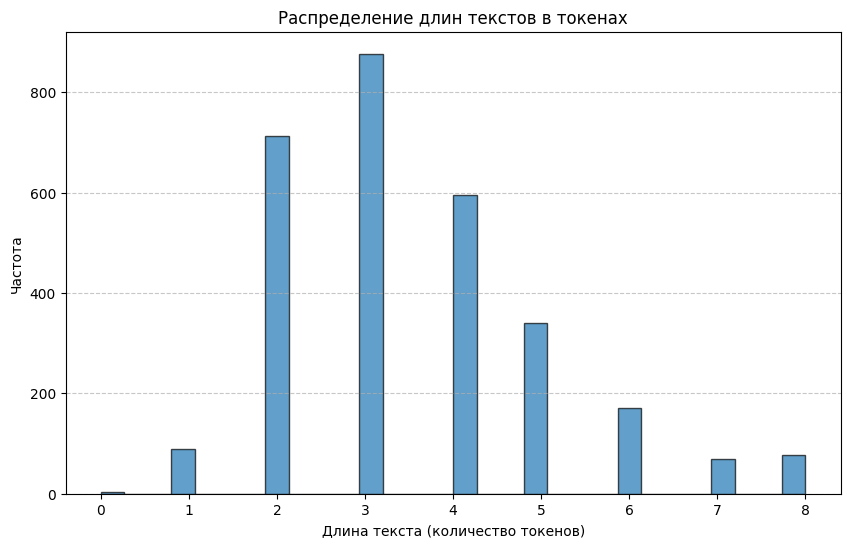

In [239]:
val_dataset.plot_token_length_distribution()

# Модель

In [240]:
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

# # model.gradient_checkpointing_enable()
model.reset_crf_parameters()
model

Some weights of AutoModelForTokenClassificationWithCRF were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['backbone.embeddings.LayerNorm.bias', 'backbone.embeddings.LayerNorm.weight', 'backbone.embeddings.position_embeddings.weight', 'backbone.embeddings.token_type_embeddings.weight', 'backbone.embeddings.word_embeddings.weight', 'backbone.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.attention.self.key.bias', 'backbone.encoder.layer.0.attention.self.key.weight', 'backbone.encoder.layer.0.attention.self.query.bias', 'backbone.encoder.layer.0.attention.self.query.weight', 'backbone.encoder.layer.0.attention.self.value.bias', 'backbone.encoder.layer.0.attention.self.value.weight', 'backbone.encoder.layer.0.intermediate.dense.bias', '

AutoModelForTokenClassificationWithCRF(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,)

In [241]:
print("CRF transitions nan?", torch.isnan(model.crf.transitions).any())
print("CRF transitions min/max:", model.crf.transitions.min(), model.crf.transitions.max())

CRF transitions nan? tensor(False)
CRF transitions min/max: tensor(-0.0968, grad_fn=<MinBackward1>) tensor(0.0983, grad_fn=<MaxBackward1>)


# Обучение

In [242]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_PATH_SAVE_MODELS / MODEL_CHECKPOINT_PATH,  # Папка для сохранения моделей
    num_train_epochs=8,  # Количество эпох

    # eval_strategy="epoch",  # Оценка модели после каждой эпохи
    eval_strategy="steps",
    eval_steps=100,  # Оценка модели каждый шаг
    # logging_strategy="epoch",  # Логирование каждые N шагов
    logging_strategy="steps",
    logging_steps=100,  # Как часто логировать
    disable_tqdm=False,  # Отключить tqdm (нужно для работы в Colab/Kaggle)
    report_to="tensorboard",  # Логируем в TensorBoard
    logging_dir=DATA_LOG,  # Папка для логов

    # save_strategy="epoch",  # Сохранение модели после каждой эпохи
    save_strategy="steps",
    save_steps=100, # Если save_strategy="steps"
    save_total_limit=2,  # Храним все
    load_best_model_at_end=True,  # Загружать лучшую модель после обучения
    metric_for_best_model="eval_f1_macro",  # Выбираем лучшую модель по eval_f1_macro
    greater_is_better=True,  # Чем меньше eval_loss, тем лучше модель


    per_device_train_batch_size=BATCH_SIZE,  # Размер батча на одно устройство (GPU/CPU)
    per_device_eval_batch_size=BATCH_SIZE,  # Размер батча для валидации
)


In [243]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

steps_per_epoch = len(train_dataset.df) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs


In [244]:
# from transformers import get_cosine_schedule_with_warmup

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.40 * total_steps),
#     num_training_steps=total_steps 
# )

In [245]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
    num_cycles=2,
)


In [246]:
# from transformers import get_polynomial_decay_schedule_with_warmup

# scheduler = get_polynomial_decay_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     lr_end=1e-6,
#     power=2.0,
# )


In [247]:
# from transformers import get_constant_schedule_with_warmup

# scheduler = get_constant_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
# )


In [248]:
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [249]:
from collections import Counter

import numpy as np
import torch
from torch.nn import CrossEntropyLoss


def compute_class_weights(train_dataset, num_labels, max_weight: float = 10.0, smoothing: float = 1.0):
    all_labels = []
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)
    counts = Counter(all_labels)
    total = sum(counts.values())
    class_weights = [total / (counts.get(i, 0) + smoothing) for i in range(num_labels)]
    class_weights = np.array(class_weights, dtype=np.float32)
    class_weights = class_weights / class_weights.sum()
    class_weights = np.clip(class_weights, 0.0, max_weight)
    return torch.tensor(class_weights, dtype=torch.float32)

def weighted_crf_loss(
    emissions,
    labels,
    attention_mask,
    crf,
    class_weights_tensor,
    alpha=0.7,
):
    labels_for_crf = labels.clone().long()
    labels_for_crf[labels_for_crf == -100] = 0

    crf_loss = -crf(
        emissions,
        labels_for_crf,
        mask=attention_mask.bool(),
        reduction="token_mean"
    )

    logits_flat = emissions.view(-1, emissions.size(-1))
    labels_flat = labels.view(-1)
    ce_loss_fn = CrossEntropyLoss(
        weight=class_weights_tensor.to(emissions.device),
        ignore_index=-100
    )
    ce_loss = ce_loss_fn(logits_flat, labels_flat)
    total_loss = alpha * crf_loss + (1 - alpha) * ce_loss
    return total_loss


def weighted_loss(
    outputs: "TokenClassifierCRFOutput",
    labels,
    model,
    class_weights_tensor,
    alpha=0.7,
    num_items_in_batch=None,
):
    emissions = outputs.logits
    loss = weighted_crf_loss(
        emissions=emissions,
        labels=labels,
        attention_mask=outputs.attention_mask,
        crf=model.crf,
        class_weights_tensor=class_weights_tensor,
        alpha=alpha,
    )
    return loss


In [250]:
class_weights_tensor = compute_class_weights(train_dataset, num_labels, max_weight=10.0, smoothing=1.0)

In [251]:
from functools import partial

from ml.trainer import CustomBaseTrainer
from ml.metrics import compute_metrics

trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.5)
)

In [173]:
trainer.train()

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Precision,Recall,F1 Micro,F1 Macro,Accuracy
100,1.791400,1.227985,0.483871,0.506135,0.494753,0.200883,0.810648
200,0.965100,0.940913,0.498147,0.618609,0.551881,0.246468,0.834694
300,0.644200,0.650628,0.539299,0.684049,0.603110,0.349599,0.873392
400,0.484500,0.562594,0.607262,0.743865,0.668658,0.405601,0.890616
500,0.378600,0.509235,0.677686,0.796524,0.732315,0.470438,0.909518
600,0.302700,0.498042,0.716592,0.816973,0.763497,0.508968,0.916900
700,0.265700,0.423751,0.742348,0.830777,0.784077,0.592789,0.921709
800,0.226600,0.463791,0.739664,0.832311,0.783257,0.558383,0.922380
900,0.208500,0.437455,0.766294,0.841513,0.802144,0.575140,0.924841
1000,0.203300,0.474302,0.758206,0.838446,0.796310,0.616242,0.924058


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Projects\env_ml\.venv\

TrainOutput(global_step=1944, training_loss=0.34255959688390725, metrics={'train_runtime': 584.3988, 'train_samples_per_second': 424.067, 'train_steps_per_second': 3.326, 'total_flos': 35727517221120.0, 'train_loss': 0.34255959688390725, 'epoch': 8.0})

In [174]:
# trainer.plot_results()

In [175]:
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'test_loss': 0.5029035806655884, 'test_precision': 0.7857142857142857, 'test_recall': 0.84326171875, 'test_f1_micro': 0.8134715025906736, 'test_f1_macro': 0.702132056446705, 'test_accuracy': 0.9239406779661017, 'test_runtime': 1.0731, 'test_samples_per_second': 1600.074, 'test_steps_per_second': 13.047}


In [176]:
trainer.save_model(DATA_PATH_SAVE_MODELS / MODEL_NAME_SAVE)

# Тестирование модели

In [252]:
from regex import D
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5_tiny_89",
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5_tiny_89",
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

# model.gradient_checkpointing_enable()

In [253]:
trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.85)
)

test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 0.5219087600708008, 'test_model_preparation_time': 0.001, 'test_precision': 0.6579457364341085, 'test_recall': 0.749034749034749, 'test_f1_micro': 0.7005416559195253, 'test_f1_macro': 0.3756975690414672, 'test_accuracy': 0.8792055280746139, 'test_runtime': 2.4947, 'test_samples_per_second': 2004.263, 'test_steps_per_second': 16.034}


In [254]:
test_dataset.analyze_with_model(
    model=model, 
    idx2label=idx2label, 
    batch_size=64, 
    device="cuda" if torch.cuda.is_available() else "cpu", 
    layer=-1
)

In [255]:
# test_dataset.df.sample(10)

In [256]:
print(test_dataset.df["is_correct"].value_counts())

is_correct
True     3733
False    1267
Name: count, dtype: int64


In [257]:
df_true = test_dataset.df[test_dataset.df["is_correct"] == True]
df_true.sample(5)

,sample,annotation,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
2411,гранолы,"[(0, 7, B-TYPE)]","[2, 58040, 43080, 3, 0, 0, 0, 0, 0, 0]","[[CLS], гран, ##олы, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'гранолы'}]",True
4282,карсулы,"[(0, 7, B-TYPE)]","[2, 8573, 4108, 2520, 3, 0, 0, 0, 0, 0]","[[CLS], кар, ##су, ##лы, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'карсулы'}]",True
2417,сочнтк,"[(0, 6, B-TYPE)]","[2, 39821, 4406, 865, 3, 0, 0, 0, 0, 0]","[[CLS], соч, ##нт, ##к, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'сочнтк'}]",True
3081,туалентная,"[(0, 10, B-TYPE)]","[2, 34598, 4406, 1545, 3, 0, 0, 0, 0, 0]","[[CLS], туале, ##нт, ##ная, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 10, 'entity': 'B-TYPE', 'word': 'туалентная'}]",True
1686,umka карандаш,"[(0, 4, B-BRAND), (5, 13, B-TYPE)]","[2, 701, 767, 77955, 3, 0, 0, 0, 0, 0]","[[CLS], um, ##ka, карандаш, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, B-TYPE, O, O, O, O, O, O]","[O, B-BRAND, I-BRAND, B-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-BRAND', 'word': 'umka'}, {'start_index': 5, 'end_index': 13, 'entity': 'B-TYPE', 'word': 'карандаш'}]",True


In [267]:
df_false = test_dataset.df[test_dataset.df["is_correct"] == False]
df_false.sample(10)

,sample,annotation,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
3935,наггетсы сызрань,"[(0, 8, B-TYPE), (9, 16, I-TYPE)]","[2, 53528, 2202, 28834, 700, 44352, 31834, 3561, 3, 0]","[[CLS], наг, ##ге, ##тс, ##ы, сы, ##зра, ##нь, [SEP], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, I-TYPE, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-TYPE', 'word': 'наггетсы'}, {'start_index': 9, 'end_index': 16, 'entity': 'B-BRAND', 'word': 'сызрань'}]",False
4489,производство укро,"[(0, 12, B-TYPE), (13, 17, I-TYPE)]","[2, 10824, 6002, 721, 3, 0, 0, 0, 0, 0]","[[CLS], производство, укр, ##о, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-BRAND, B-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 12, 'entity': 'B-BRAND', 'word': 'производство'}, {'start_index': 13, 'end_index': 17, 'entity': 'B-TYPE', 'word': 'укро'}]",False
4429,чай с ромашкой детский,"[(0, 3, B-TYPE), (4, 5, I-TYPE), (6, 14, I-TYPE), (15, 22, I-TYPE)]","[2, 36971, 329, 69074, 32873, 34025, 3, 0, 0, 0]","[[CLS], чай, с, рома, ##шкой, детский, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 3, 'entity': 'B-TYPE', 'word': 'чай'}, {'start_index': 4, 'end_index': 5, 'entity': 'O', 'word': 'с'}, {'start_index': 6, 'end_index': 14, 'entity': 'O', 'word': 'ромашкой'}, {'start_index': 15, 'end_index': 22, 'entity': 'O', 'word': 'детский'}]",False
3099,тмин мэтр,"[(0, 4, B-TYPE), (5, 9, I-TYPE)]","[2, 330, 14010, 324, 9287, 870, 3, 0, 0, 0]","[[CLS], т, ##мин, м, ##эт, ##р, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'тмин'}, {'start_index': 5, 'end_index': 9, 'entity': 'B-BRAND', 'word': 'мэтр'}]",False
594,нф ошейни,"[(0, 2, B-TYPE), (3, 9, I-TYPE)]","[2, 325, 2698, 64027, 958, 3, 0, 0, 0, 0]","[[CLS], н, ##ф, ошей, ##ни, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, B-BRAND, I-BRAND, B-TYPE, I-TYPE, O, O, O, O, O]","[{'start_index': 0, 'end_index': 2, 'entity': 'B-BRAND', 'word': 'нф'}, {'start_index': 3, 'end_index': 9, 'entity': 'B-TYPE', 'word': 'ошейни'}]",False
4357,рыбки с луком,"[(0, 5, B-TYPE), (6, 7, I-TYPE), (8, 13, I-TYPE)]","[2, 41256, 954, 329, 77581, 3, 0, 0, 0, 0]","[[CLS], рыб, ##ки, с, луком, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'рыбки'}, {'start_index': 6, 'end_index': 7, 'entity': 'O', 'word': 'с'}, {'start_index': 8, 'end_index': 13, 'entity': 'O', 'word': 'луком'}]",False
4610,йогурт станция молочная,"[(0, 6, B-TYPE), (7, 14, I-TYPE), (15, 23, I-TYPE)]","[2, 54265, 6033, 12072, 29606, 8754, 3, 0, 0, 0]","[[CLS], йогу, ##рт, станция, моло, ##чная, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 14, 'entity': 'B-BRAND', 'word': 'станция'}, {'start_index': 15, 'end_index': 23, 'entity': 'I-BRAND', 'word': 'молочная'}]",False
1393,коровка из кореновк,"[(0, 7, B-TYPE), (8, 10, I-TYPE), (11, 19, I-TYPE)]","[2, 46434, 872, 778, 23279, 39186, 865, 3, 0, 0]","[[CLS], коров, ##ка, из, кор, ##енов, ##к, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[O, B-BRAND, I-BRAND, O, O, I-TYPE, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-BRAND', 'word': 'коровка'}, {'start_index': 8, 'end_index': 10, 'entity': 'O', 'word': 'из'}, {'start_index': 11

In [259]:
# test_dataset.visualize_embeddings(
#     source="mean",
#     method='tsne', 
#     n_components=2,
#     n_samples=1000,
#     # cluster_method='kmeans',
#     # n_clusters=10,
#     # use_clusters=True,
#     use_opacity=False,
#     idx2label=idx2label,
#     colorscale_name='rainbow',
#     hover_columns=['sample', 'annotation'],
#     plot_width=1800,
#     plot_height=600,
# )

# Ручное тестирование

In [260]:
import json
from pathlib import Path

from ml.pipline import NERPipelineCRF

model_dir = DATA_PATH_SAVE_MODELS / "ner_x5"
label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "r", encoding="utf-8") as f:
    label2idx = json.load(f)

with open(idx2label_path, "r", encoding="utf-8") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}

pipeline = NERPipelineCRF(
    model_path=model_dir,
    label2idx=label2idx,
    idx2label=idx2label,
    max_length=16
)


In [261]:
text = [
    "йогурт данисимо фантазия",
    "молоко простоквашино 3.2% 930г",
    "хлеб бородинский нарезка 300г",
    "мороженнае как бы его взтять",
    "молоко⁷ цельное",
    "погремушки fisher-pri",   
    "сырокопченая-колбаск",
    "мясное пюре для пупсов"
]
entities = pipeline.predict(text, return_word=True)

for i, entity in enumerate(entities):
    print(f"Текст: {text[i]}")
    print(entity)

Текст: йогурт данисимо фантазия
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'данисимо'}, {'start_index': 16, 'end_index': 24, 'entity': 'I-BRAND', 'word': 'фантазия'}]
Текст: молоко простоквашино 3.2% 930г
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'молоко'}, {'start_index': 7, 'end_index': 20, 'entity': 'B-BRAND', 'word': 'простоквашино'}, {'start_index': 21, 'end_index': 25, 'entity': 'B-PERCENT', 'word': '3.2%'}, {'start_index': 26, 'end_index': 30, 'entity': 'B-BRAND', 'word': '930г'}]
Текст: хлеб бородинский нарезка 300г
[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'хлеб'}, {'start_index': 5, 'end_index': 16, 'entity': 'I-TYPE', 'word': 'бородинский'}, {'start_index': 17, 'end_index': 24, 'entity': 'O', 'word': 'нарезка'}, {'start_index': 25, 'end_index': 29, 'entity': 'B-VOLUME', 'word': '300г'}]
Текст: мороженнае как бы его взтять
[{'start_index

In [262]:
import pandas as pd
from tqdm import tqdm

def run_inference_on_dataframe(
    pipeline, 
    df: pd.DataFrame,
    text_col: str = "sample", 
    batch_size: int = 64
) -> pd.DataFrame:
    
    texts = df[text_col].tolist()
    all_entities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Running inference", ncols=100):
        batch_texts = texts[i:i+batch_size]
        batch_entities = pipeline.predict(batch_texts, batch_size=batch_size)
        all_entities.extend(batch_entities)

    formatted_entities = [
        [(ent["start_index"], ent["end_index"], ent["entity"]) for ent in ents]
        for ents in all_entities
    ]

    df_result = pd.DataFrame({
        "id": range(1, len(texts) + 1),
        "search_query": texts,
        "annotation": formatted_entities
    })

    return df_result


In [263]:
df_result = run_inference_on_dataframe(pipeline, df_submission, text_col="sample", batch_size=64)


Running inference: 100%|████████████████████████████████████████████| 79/79 [00:03<00:00, 21.91it/s]


In [264]:
df_result.sample(5)

,id,search_query,annotation
673,674,наполнителл,"[(0, 11, B-TYPE)]"
1880,1881,ветчина из грудки индейки,"[(0, 7, B-TYPE), (8, 10, O), (11, 17, O), (18, 25, O)]"
4669,4670,на конфтами,"[(0, 2, B-TYPE), (3, 11, I-TYPE)]"
107,108,чаек,"[(0, 4, B-TYPE)]"
439,440,овсянок,"[(0, 7, B-TYPE)]"


In [265]:
df_result.to_csv(DATA_PATH_DOWNLOAD /  "submission.csv", index=False, sep=";")
